In [1]:
#mount google drive when on google colaboratory

from google.colab import drive
drive.mount('/content/drive')

#set repo path and check repo status
repo_path = '/content/drive/MyDrive/geomsha/'
%cd /content/drive/MyDrive/geomsha/
!git status


Mounted at /content/drive
/content/drive/MyDrive/geomsha
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [1]:
#initialize environment, load modules/libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#import python code from seperate files
from utils.generators import gen_shapes, gen_noise, gen_image, gen_details
from utils.helpers import gen_grid_image

rnd=np.random.default_rng(31)


In [2]:
num_images=2

num_shapes=64
max_radius=1/20
min_radius=1/40

num_noise=300
max_line=1/20
min_line=1/80

im_size=1024
max_lw=0.15
min_lw=0.1

radius = int(max_radius*im_size)+1
detail_im_size = 2*radius+1

fluct=0

In [3]:
images = []
labels = []
details = []
boxes = []

for i in range(num_images) :
    shapes = gen_shapes(rnd, num_shapes, max_radius, min_radius, False, False)
    noise = gen_noise(rnd, num_noise, max_line, min_line)
    img, sha, nse, box = gen_image(shapes, noise, rnd, im_size, max_lw, min_lw, False)
    focus = gen_details(detail_im_size, sha, img, rnd, fluct)
    images.append(img)
    labels.append(sha)
    details.append(focus)
    boxes.append(box)

plt.close()

np.savez_compressed('data/data.npz', images=images, labels=labels, details=details, boxes=boxes)

In [4]:
loaded  = np.load('data/data.npz')
images = loaded['images']
labels = loaded['labels']
details = loaded['details']
boxes = loaded['boxes']

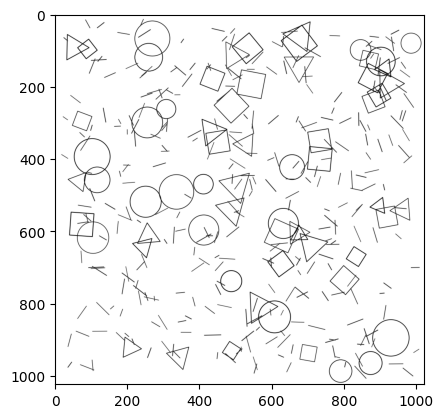

In [5]:
image=images[0]

fig = plt.figure(figsize=(image.shape[1],image.shape[0]),dpi=1)
fig.figimage(image, cmap='gray')
fig.savefig('data/tmp_image.png')
plt.close()

plt.imshow(mpimg.imread('data/tmp_image.png'))

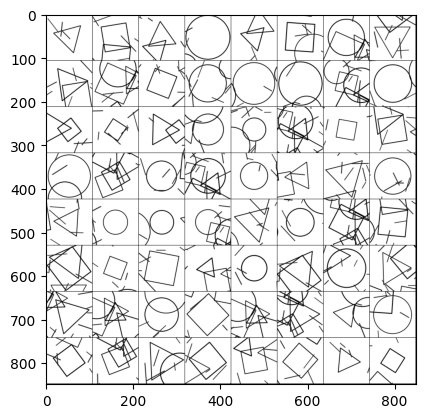

In [6]:
image=images[0]
detail=details[0]

grid = (8,8)
grid_image, grid_pos = gen_grid_image(detail, grid)

fig = plt.figure(figsize=(grid_image.shape[1],grid_image.shape[0]),dpi=1)
fig.figimage(grid_image, cmap='gray')
fig.savefig('data/tmp_grid.png')
plt.close()

plt.imshow(mpimg.imread('data/tmp_grid.png'))

In [7]:
label=labels[0]

print("\nposition : shape : [pos_x, pos_y, size, rotation, line_width]")
np.set_printoptions(precision=3, suppress=True)
for i in range(grid[0]*grid[1]):
    print(f"{grid_pos[i]} : {int(label[i][0])} {label[i][1:]}")


position : shape : [pos_x, pos_y, size, rotation, line_width]
(0, 0) : 3 [344.319  75.805  37.069   1.316   0.116]
(0, 1) : 4 [732.612 673.261  40.908   0.95    0.127]
(0, 2) : 3 [258.277 409.837  36.294   0.087   0.123]
(0, 3) : 2 [929.607 127.644  50.438   0.      0.133]
(0, 4) : 3 [245.354 380.276  31.946   1.296   0.135]
(0, 5) : 4 [ 74.045 441.77   44.89    0.715   0.147]
(0, 6) : 2 [632.108 444.373  41.672   0.      0.135]
(0, 7) : 3 [675.144 881.508  47.131   1.052   0.1  ]
(1, 0) : 3 [433.355 698.75   43.063   0.665   0.137]
(1, 1) : 4 [626.569 410.394  50.681   0.366   0.111]
(1, 2) : 4 [435.836 844.888  37.729   0.411   0.128]
(1, 3) : 2 [255.19  723.86   42.656   0.      0.126]
(1, 4) : 2 [336.16  531.615  47.835   0.      0.117]
(1, 5) : 2 [102.89  629.419  49.715   0.      0.139]
(1, 6) : 4 [868.881 896.975  31.298   0.555   0.108]
(1, 7) : 2 [250.871 504.458  43.063   0.      0.131]
(2, 0) : 4 [ 89.769 927.3    27.362   1.445   0.147]
(2, 1) : 4 [488.552  92.493  25.92  

In [8]:
box=boxes[0]

print("\nposition : [x_min, x_max, y_min, y_max]")
np.set_printoptions(precision=3, suppress=True)
for i in range(grid[0]*grid[1]):
    print(f"{grid_pos[i]} : {box[i]}")


position : [x_min, x_max, y_min, y_max]
(0, 0) : [308.449 370.353  40.065 102.193]
(0, 1) : [699.341 765.884 639.989 706.532]
(0, 2) : [228.546 291.17  389.021 445.993]
(0, 3) : [879.168 980.045  77.205 178.082]
(0, 4) : [214.604 268.229 349.316 402.576]
(0, 5) : [ 40.161 107.93  407.885 475.655]
(0, 6) : [590.437 673.78  402.701 486.044]
(0, 7) : [634.226 715.859 834.377 905.249]
(1, 0) : [406.798 475.991 658.801 732.649]
(1, 1) : [579.241 673.897 363.066 457.722]
(1, 2) : [401.25  470.423 810.302 879.475]
(1, 3) : [212.535 297.846 681.204 766.515]
(1, 4) : [288.325 383.996 483.78  579.451]
(1, 5) : [ 53.175 152.605 579.704 679.134]
(1, 6) : [842.284 895.477 870.378 923.571]
(1, 7) : [207.808 293.934 461.395 547.521]
(2, 0) : [ 62.622 116.916 900.153 954.446]
(2, 1) : [463.196 513.907  67.137 117.848]
(2, 2) : [ 32.724  94.396 897.015 967.354]
(2, 3) : [ 81.178 152.341 529.402 600.565]
(2, 4) : [281.449 334.454 734.497 787.502]
(2, 5) : [884.278 929.72  849.944 899.371]
(2, 6) : [677